In [55]:
from negmas.preferences.ops import (
    pareto_frontier_numpy, pareto_frontier_numpy_faster, 
    pareto_frontier_convex_hull, pareto_frontier_of, 
    pareto_frontier_chatgpt, pareto_frontier_bf
)
import numpy as np
from collections import defaultdict
from rich import print
from time import perf_counter
from negmas.helpers import humanize_time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [56]:
n_outcomes = [10, 100, 1000, 10_000, 100_000, 1000_000]
n_negotiators = [2, 3]
n_trials = [max(3, max(n_outcomes)) // _ for _ in n_outcomes]
eps, presort = 1e-12, True
BFLIMIT = 100_1001

utillist = ([[[
    np.random.rand(n, m) 
    for _ in range(n_trials[i])] 
    for m in n_negotiators]
    for i, n in enumerate(n_outcomes)])
data = []
def tryonce(alg, i, j, t, eps=eps, utillist=utillist):
    utils = utillist[i][j][t]
    start = perf_counter()    
    pareto = alg(utils, sort_by_welfare=False, eps=eps)
    data.append(dict(method=alg.__name__.replace("pareto_frontier_", ""), 
                     n_outcomes=n_outcomes[i], n_negotiators=n_negotiators[j], trial=t,
                   time=perf_counter() - start))
    return list(pareto)

In [57]:
t = perf_counter()
bf = [[[
    tryonce(pareto_frontier_bf, n, m, t) if n_outcomes[n] < BFLIMIT else []
    for t in range(n_trials[n])] 
    for m in range(len(n_negotiators))] 
    for n in range(len(n_outcomes))]
print(humanize_time(perf_counter() - t, show_us=True))

/Users/yasser/code/projects/negmas/negmas/preferences/ops.py:295: NegmasSlowOperation: Pareto's Quadratic Operation is too Slow: n.ops=100,000,000 (n=10,000), limit=100,000,000
  warn_if_slow(
/Users/yasser/code/projects/negmas/negmas/preferences/ops.py:295: NegmasSlowOperation: Pareto's Quadratic Operation is too Slow: n.ops=10,000,000,000 (n=100,000), limit=100,000,000
  warn_if_slow(
/Users/yasser/code/projects/negmas/negmas/preferences/ops.py:295: NegmasSlowOperation: Pareto's Quadratic Operation is too Slow: n.ops=1,000,000,000,000 (n=1,000,000), limit=100,000,000
  warn_if_slow(


18m 8s893ms477u

In [58]:
t = perf_counter()
numpy = [[[tryonce(pareto_frontier_numpy, n, m, t) 
    for t in range(n_trials[n])] 
    for m in range(len(n_negotiators))] 
    for n in range(len(n_outcomes))]
print(humanize_time(perf_counter() - t, show_us=True))

8s772ms336u

In [59]:
t = perf_counter()
# numpy_faster = [[[tryonce(pareto_frontier_numpy_faster, n, m, t) for t in range(n_trials[n])] for m in range(len(n_negotiators))]  for n in range(len(n_outcomes))]
print(humanize_time(perf_counter() - t, show_us=True))

14u

In [60]:
t = perf_counter()
# convex_hull = [[[tryonce(pareto_frontier_convex_hull, n, m, t) for t in range(n_trials[n])] for m in range(len(n_negotiators))]  for n in range(len(n_outcomes))]
print(humanize_time(perf_counter() - t, show_us=True))

19u

In [61]:
t = perf_counter()
# chatgpt = [[[tryonce(pareto_frontier_chatgpt, n, m, t) for t in range(n_trials[n])] for m in range(len(n_negotiators))]  for n in range(len(n_outcomes))]
print(humanize_time(perf_counter() - t, show_us=True))

17u

In [62]:
# print(chatgpt)

In [63]:
algs = dict(numpy=numpy,
            brute_force=bf
            # numpy_faster=numpy_faster, 
            # convex_hull=convex_hull, 
            # chatgpt=chatgpt
           )
alg_differences = defaultdict(list)
for alg_name, alg_results in algs.items():
    for i, n in enumerate(n_outcomes):
        if n >= BFLIMIT:
            continue
        for j, m in enumerate(n_negotiators):
            for t in range(n_trials[i]):
                a, b = tuple(sorted(bf[i][j][t])), tuple(sorted(alg_results[i][j][t]))
                if a[0] == b[0]:
                    continue
                alg_differences[alg_name].extend((a, b))

print(alg_differences)

defaultdict(<class 'list'>, {})

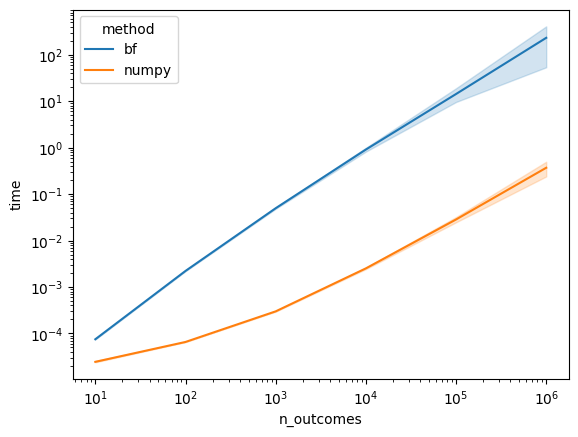

In [64]:
data = pd.DataFrame(data)
sns.lineplot(data=data, x="n_outcomes", y="time", hue="method")
plt.xscale('log')
plt.yscale('log')